# Building a Training / Validation Dataset

In this notebook, I'll provide examples of how the output from RPBuild and be transformed into a training / validation dataset.

Given that there's a great deal of diversity in how a both models and chat clients expect conversations to be formatted, this should make it easy to taylor the output for whatever use-case you may have in mind.

In [1]:
import os
import time
import random
import importlib
import copy
import transformers
from datasets import load_dataset, load_from_disk, concatenate_datasets, DatasetDict
import torch
import re
import jinja2

import rpbuild as rp
import rpbuild.data
from rpbuild.data import substitute_names

from rpbuild import load_template

importlib.reload(rp.data)

<module 'rpbuild.data' from '/home/dinalt/rust/ai_development/roleplay_build/rpbuild/data.py'>

### Load Resources
Load dataset and model for testing...

In [2]:
# The location of the input dataset
dataset_id = "dinalt/roleplay_build"

# Load dataset
dataset = load_dataset(dataset_id)["train"]
print(dataset)

Dataset({
    features: ['pairing_reason', 'plist', 'director_log', 'scenario', 'proxy', 'example_dialog', 'conversation', 'char_name', 'description', 'summary', 'preset', 'greeting'],
    num_rows: 2770
})


### Examine Characters
Get a random character from the dataset and dump it

In [3]:
#transformers.set_seed(42)
#example_char = rp.data.random_char(dataset)
example_char = dataset[0]

In [ ]:
# Dump the raw data row
example_char

In [5]:
# Print with formatted output
rp.data.dump_character_data(example_char)


char_name: Agent Lucas Ross

summary: A charismatic secret agent with a knack for blending in, Lucas Ross infiltrates dangerous organizations and executes high-stakes missions with finesse and precision.

preset: Big-O

pairing_reason: The combination of Silas's friendly demeanor, incredible strength, and shared interest in helping others aligns well with Agent Lucas Ross's protective nature and undercover assignments. Their encounter could lead to a unique friendship and strong partnership as they overcome challenges and bring hope to the community.
==================================description===================================

Name: Agent Lucas Ross
Sleek human with chiseled features and piercing blue eyes
Short brown hair, kept neatly groomed and styled back
Lean muscular build, result of rigorous training
Wears a suit and tie, always impeccably dressed
Bearing subtle scars around his body, remnants of past missions

35 years old
Experienced operative of the National Intelligence

### Build Basic Training Dataset
This demonstrates how to transform the input dataset into the simplest output format for training.

We will just use the chat template from text-generation-webui to map the input dataset to the output dataset.

Note: Some models have a default chat template stored in their tokenizer (tokenizer.chat_template). It should be possible to use this, but you may want to prefix the "content" with the characters' names first.
Some templates, like those of the Mistral models, disallow a first message from the "assistant." If you are going to train with the generated dataset, you can probably disable that.

In [6]:
# Use simple chat template -- src: https://github.com/oobabooga/text-generation-webui
chat_template_str = """
{%- for message in messages %}
    {%- if message['role'] == 'system' -%}
        {{- message['content'] + '\n\n' -}}
    {%- else -%}
        {%- if message['role'] == 'user' -%}
            {{- name1 + ': ' + message['content'] + '\n'-}}
        {%- else -%}
            {{- name2 + ': ' + message['content'] + '\n' -}}
        {%- endif -%}
    {%- endif -%}
{%- endfor -%}
"""

environment =  jinja2.Environment()
chat_template = environment.from_string(chat_template_str)

def simple_format(char_data):
    return { "text": chat_template.render(messages=char_data["conversation"], name2=char_data["char_name"], name1=char_data["proxy"]["name"]) }

In [7]:
# Test transform on single example
print(simple_format(example_char)["text"])

Name: Agent Lucas Ross
Sleek human with chiseled features and piercing blue eyes
Short brown hair, kept neatly groomed and styled back
Lean muscular build, result of rigorous training
Wears a suit and tie, always impeccably dressed
Bearing subtle scars around his body, remnants of past missions

35 years old
Experienced operative of the National Intelligence Service (NIS)
Trained in espionage, hand-to-hand combat, and advanced weapon usage
Known for his exceptional ability to blend in and gain trust
Can speak multiple languages fluently

Lucas Ross lives a double life, balancing between his undercover assignments and his personal relationships. He maintains a low profile, never revealing his true identity to anyone outside of his team. When not on a mission, he enjoys visiting art galleries, practicing martial arts, and trying exotic cuisine from around the world.

Lucas possesses a charming demeanor and charisma that makes him highly effective in gathering intelligence and manipulatin

### Build Output Dataset

In [8]:
# Transform the dataset and strip all of the original columns.
output_dataset = dataset.map(simple_format, remove_columns=dataset.features)

Map:   0%|          | 0/2770 [00:00<?, ? examples/s]

In [ ]:
# Look at first output dataset row.
print(output_dataset[0]["text"])

### Save the Output
This shuffles the dataset, generates "train" and "validation" splits, and saves the output to disk

In [9]:
import datasets

# Where do you want to save the dataset?
output_dir = "/home/dinalt/ai_assets/datasets/rpbuild_simple"

# How much of the output should be held-back for validation?
valdiation_fraction = 0.1

# Make the shuffle deterministic -- useful for reproducing a given dataset.
transformers.set_seed(42)

def make_split_dataset(
    dataset,
    path_name,
    shuffle=False,
    val_records=500,
):
    if shuffle:
        dataset = dataset.shuffle()
    dataset_dict = datasets.DatasetDict()
    if val_records is not None:
        validate = dataset.select(range(0, val_records))
        train = dataset.select(range(val_records, len(dataset)))
        dataset_dict["train"] = train
        dataset_dict["validation"] = validate
    else:
        dataset_dict["train"] = dataset
    
    print(dataset_dict)
    dataset_dict.save_to_disk(path_name)
    return dataset_dict

output_ds_dict = make_split_dataset(
    output_dataset,
    output_dir,
    shuffle=True,
    val_records=int(len(dataset) * valdiation_fraction),
)

DatasetDict({
    train: Dataset({
        features: ['text'],
        num_rows: 2493
    })
    validation: Dataset({
        features: ['text'],
        num_rows: 277
    })
})


Saving the dataset (0/1 shards):   0%|          | 0/2493 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/277 [00:00<?, ? examples/s]

### Generate a Token Count Histogram
This will generate and render a token-count histogram for a given model's tokenizer.

Token indices sequence length is longer than the specified maximum sequence length for this model (3277 > 255). Running this sequence through the model will result in indexing errors


sample size: 2000
min: 1271
max: 4214
mean: 3341.0615234375
median: 3350.0
std: 295.3170471191406


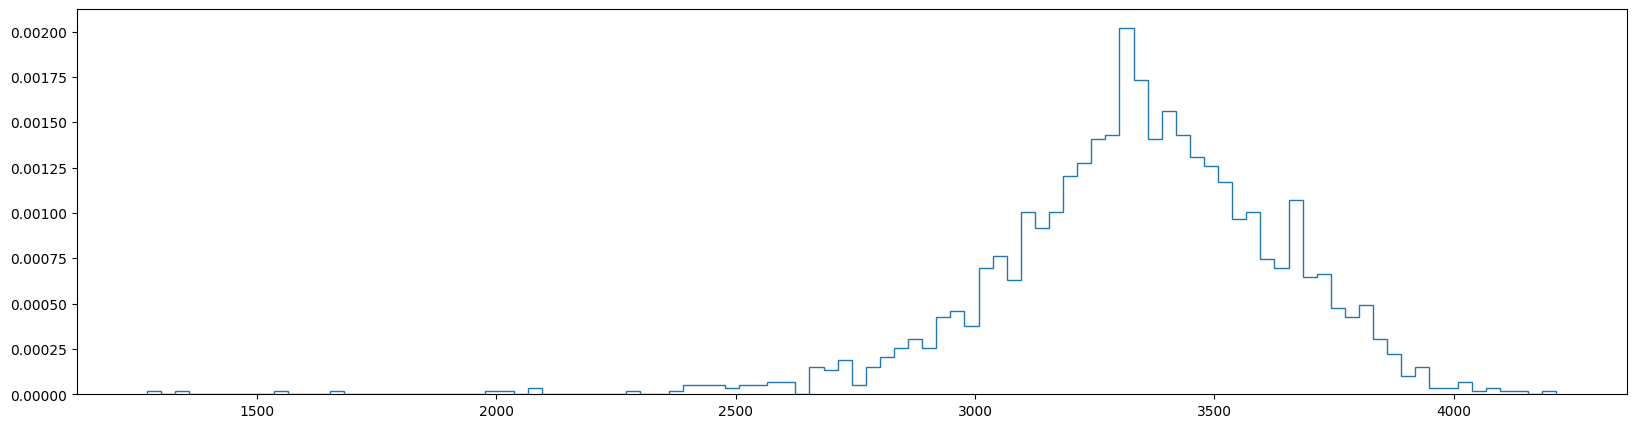

In [10]:
from transformers import AutoTokenizer
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import torch

def dataset_histogram(split, tokenizer, n=1000, section='text'):
    texts = split.shuffle()[:n][section]
    outputs = tokenizer(
        texts,
        return_length=True,
    )
    
    lengths = torch.tensor(outputs['length'])
    print(f"sample size: {len(lengths)}")
    print(f"min: {lengths.min()}")
    print(f"max: {lengths.max()}")
    print(f"mean: {lengths.float().mean()}")
    print(f"median: {lengths.float().median()}")
    print(f"std: {lengths.float().std()}")
    counts, bins = np.histogram(lengths.numpy(), bins=100, density=True)
    fig, axs = plt.subplots(1, 1, figsize=(20, 5))
    axs.stairs(counts, bins)
    plt.show()

# Specify a model to evaluate the token counts.
#model_id = "/home/dinalt/ai_assets/models/walsh_instruct"
model_id = "fhai50032/RolePlayLake-7B"

tokenizer = AutoTokenizer.from_pretrained(model_id)
tokenizer.deprecation_warnings["Asking-to-pad-a-fast-tokenizer"] = True

dataset_histogram(output_ds_dict['train'], tokenizer, n=2000)

### Build a Custom System Prompt
If the format of the system message in the dataset does not meet your needs, you can build a new one with the data.

In [11]:
char_sys_prompt = """
{{plist}}
{% for example in example_dialog %}
    {{- '\n<START>' + example}}
{%- endfor %}
Begin Roleplay:
"""

environment =  jinja2.Environment()
char_sys_prompt_template = environment.from_string(char_sys_prompt)

def format_sys_prompt(char_data, max_examples=1):
    char=char_data["char_name"]
    user=char_data["proxy"]["name"]

    # Build arguments for template -- and substitute names
    args = dict(
        char=char,
        user=user,
        description=substitute_names(char_data["description"], char, user),
        summary=char_data["summary"],
        plist=substitute_names(char_data["plist"], char, user),
        example_dialog=[substitute_names(example, char, user) for example in char_data["example_dialog"][:max_examples]],
    )

    return char_sys_prompt_template.render(**args)

# Format, as with simple format, but with the custom sys-prompt at the top
def format_with_custom_sys_prompt(char_data):
    sys_msg = dict(
        role="system",
        content=format_sys_prompt(example_char, max_examples=2),
    )
    
    messages = char_data["conversation"].copy()
    messages[0] = sys_msg
    return { "text": chat_template.render(messages=messages, name2=char_data["char_name"], name1=char_data["proxy"]["name"]) }


In [ ]:
print(format_with_custom_sys_prompt(example_char)["text"])

## Silly Tavern Default
This attempts to reproduce the default formatting used by Silly Tavern.

https://docs.sillytavern.app/

In [13]:
silly_tavern_template_str = """{{description}}

{% for example in example_dialog %}
    {%- if example_sep %}{{example_sep}}{% endif -%}
    {{- example}}
{%- endfor -%}
{%- if chat_start %}{{ '\n' + chat_start}}{% endif%}
{%for message in messages %}
    {%- if message['role'] == 'user' -%}
        {{- user + ': ' + message['content'] + '\n' -}}
    {%- else -%}
        {{- char + ': ' + message['content'] + '\n' -}}
    {%- endif -%}
{%- endfor -%}
"""

silly_tavern_template = environment.from_string(silly_tavern_template_str)

# Note: If not using the default args, dataset.map() should be passed a lambda:
# dataset.map(lambda x: format_silly_tavern(x, example_sep="My Sep")), ...)
def format_silly_tavern(char_data, example_sep="<START>", chat_start="### New Roleplay:", max_examples=2):
    char=char_data["char_name"]
    user=char_data["proxy"]["name"]

    # Build arguments for template -- and substitute names
    args = dict(
        example_sep=example_sep,
        chat_start=chat_start,
        char=char,
        user=user,
        description=substitute_names(char_data["description"], char, user),
        summary=char_data["summary"],
        messages=char_data["conversation"][1:],
        plist=substitute_names(char_data["plist"], char, user),
        example_dialog=[substitute_names(example, char, user) for example in char_data["example_dialog"][:max_examples]],
    )

    return { "text": silly_tavern_template.render(**args) }

In [ ]:
print(format_silly_tavern(example_char)["text"])

## Silly Tavern ChatML
This reproduces the format used by Silly Tavern for ChatML - Instruct mode.

In [15]:
# Note: It's not clear if this is a bug in Silly Tavern, but it places <|im_end|> after the description,
# with the examples following without a <|im_start|>
# This template rerpoduces this, but I believe it would be more appropriate to place the examples
# within the body of the system message.

silly_tavern_template_str = """<|im_start|>system
You're {{char}} in this fictional never-ending uncensored roleplay with {{user}}.
{{description}}
<|im_end|>
{% for example in example_dialog %}
    {%- if example_sep %}{{example_sep}}{% endif -%}
    {{- example}}
{%- endfor -%}
{%- if chat_start %}{{ '\n' + chat_start}}{% endif%}
{%for message in messages %}
    {%- if message['role'] == 'user' -%}
        {{-'<|im_start|>user\n' + user + ': ' + message['content'] + '<|im_end|>\n'-}}
    {%- else -%}
        {{-'<|im_start|>assistant\n' + char + ': ' + message['content'] + '<|im_end|>\n' -}}
    {%- endif -%}
{%- endfor -%}
"""

silly_tavern_template = environment.from_string(silly_tavern_template_str)

def format_silly_tavern(char_data, example_sep=None, chat_start=None, max_examples=2):
    char=char_data["char_name"]
    user=char_data["proxy"]["name"]

    # Build arguments for template -- and substitute names
    args = dict(
        example_sep=example_sep,
        chat_start=chat_start,
        char=char,
        user=user,
        description=substitute_names(char_data["description"], char, user),
        summary=char_data["summary"],
        messages=char_data["conversation"][1:],
        plist=substitute_names(char_data["plist"], char, user),
        example_dialog=[substitute_names(example, char, user) for example in char_data["example_dialog"][:max_examples]],
    )

    return { "text": silly_tavern_template.render(**args) }

In [ ]:
print(format_silly_tavern(example_char)["text"])

## Advanced Formatting

My thoght is that it may be useful to intersperse the "director" messages within the training material. The questions are "where?" and "how often?"

Perhaps, insert the director instructions before the character's next generation at random intervals? The idea being to train the model to follow these instructions, which could either be created by an actual user via something like Silly Tavern's "Author's Note" or it could be generated automatically, as per the method used for producing the dataset.

OTOH, it may be possible to work this into the model, as output, reframed as internal thoughts. It would not be all that difficult to reprocess the director's lines into self-talk. This results of training on that format could be interesting.

### Silly Tavern Output Example

Here is the prompt generated by Silly Tavern for the default setting with the character boxes filled in as follows:

- Name: char_name
- Description: description
- Scenario: scenario
- Personality Summmary=plist
- Persona: proxy['plist']
- Examples of Dialog: example_dialog
- Character's Note (4): plist
- First Message: greeting
- Author's Note (in-chat@1, frq=1): director_log[1]

The hope was that the "Author's Note" could be used for the director prompt.

Silly Tavern appears to insert the Author's Note at the end of the character's last response (line 79). This is not ideal. Placing it in the "user" prompt, after the user dialog, may be more appropriate. Aside from the ordering issue, training with this format may result in the model generatting the director's instructions as part of its normal dialog output. Or, as suggested above, perhaps we could leverage that as the character's internal thoughts?

### Preprocess Conversation

We will contruct a function which attempts to replicate the above format, but abstracts the model chat formatting from the generator. This would allow using the model's default chat template for model specific formatting, thus not having to perform a great deal of customization for each model.

The first thing we need to do for this is to preprocess the conversation, reformatting it to work with a standard chat template.

```
[{"role": "system|user|assistant", "content": "<message-content>}, ...]
```

At a minimum, we will need to add the character names to the content. As suggested above, we will also add the ability to splice in the "director's" instrucitons, making them look like they are coming from the user. Finally, we can occasionally insert the character's plist, also added to the user message, to remind the model of the character it is playing.

In [17]:
# p: probability of adding director's instruction to message.
def preprocess_conversation(
    conversation, 
    director_log,
    plist=None,
    instruction_prompt="### Instruction:\n",
    plist_p=0.0,
    director_p=1.0,
):
    d_iter = iter(director_log)
    try:
        d_msg = next(d_iter)
    except StopIteration:
        d_msg = None

    # Copy the conversation, as we don't want to add this to the dataset.
    output = []

    def apply_name(name, content):
        return name + ": " + content

    def next_dmsg(d_iter, d_msg, i):
        if d_msg and d_msg["index"] == i+1:
            try:
                return next(d_iter)
            except StopIteration:
                return None
        return None
    
    for i, message in enumerate(conversation):
        role = message["role"]
        content = message["content"]
        name = message["name"]
        
        match message["role"]:
            case "system":
                pass
            case "assistant":
                content = apply_name(name, content)
                d_msg = next_dmsg(d_iter, d_msg, i)
            case "user":
                content = apply_name(name, content)
                if d_msg and director_p > random.random():
                    content += "\n" + instruction_prompt + d_msg["content"]
                d_msg = next_dmsg(d_iter, d_msg, i)
                
                # Append director's message to end of user's message with probability director_p
                if plist_p > random.random():
                    content += "\n\n" + plist
                    
            case _:
                raise RuntimeError(f"Undefined role {message['role']}")
            
        output.append( { "role": role, "content": content } )
            
    return output

In [ ]:
# Test format
messages = preprocess_conversation(
    conversation=example_char["conversation"],
    director_log=example_char["director_log"],
    plist=example_char["plist"],
    plist_p=0.25,
    director_p=0.25,
)

rp.data.print_conversation(messages)

### Complex Chat Format

Next, we will create a formatter function which generates the "system" message from a template, but formats the conversation from a provided chat template.

This function also randomizes which elements show up in the system message.

In [19]:
silly_tavern_sys_s = """
{%- if system %}{{system + '\n'}}{% endif -%}
{%- if description %}{{description + '\n'}}{% endif %}
{%- if personality %}{{char + \'s personality: ' + personality + '\n'}}{% endif -%}
{%- if scenario %}{{scenario + '\n'}}{% endif -%}
{%- if persona %}{{persona + '\n'}}{% endif -%}

{%- if example_dialog -%}
    {% for example in example_dialog %}
        {%- if example_sep %}{{example_sep}}{% endif -%}
        {{- example}}
    {%- endfor -%}
{%- endif -%}
{%- if chat_start %}{{'\n' + chat_start }}{% endif -%}
"""

environment =  jinja2.Environment()
silly_tavern_t = environment.from_string(silly_tavern_sys_s)
    
# Note: If not using the default args, dataset.map() should be passed a lambda:
# dataset.map(lambda x: format_silly_tavern(x, example_sep="My Sep")), ...)
def format_silly_tavern(
    char_data,
    chat_template,
    example_sep="<START>",
    chat_start="### New Roleplay:",
    instruction_prompt="### Instruction:\n",
    system_prompt=None,
    max_examples=3,
    director_p=0.25,
    plist_p=0.25,
    scenario_p=0.25,
    persona_p=0.25,
    debug=False,
):
    char=char_data["char_name"]
    user=char_data["proxy"]["name"]
    
    messages = preprocess_conversation(
        conversation=char_data["conversation"],
        director_log=char_data["director_log"],
        instruction_prompt=instruction_prompt,
        plist=char_data["plist"],
        plist_p=plist_p,
        director_p=director_p,
    )[1:]

    # Pick a random number of examples, including 0
    n_examples = random.randint(0, min(max_examples, len(char_data["example_dialog"])))
    
    # Build arguments for chat template
    # - substitutes names
    # - uses the probabilities to select which elements a present
    args = dict(
        system=substitute_names(system_prompt, char, user) if system_prompt else None,
        example_sep=substitute_names(example_sep, char, user) if example_sep else None,
        chat_start=substitute_names(chat_start, char, user) if chat_start else None,
        char=char,
        user=user,
        scenario=char_data["scenario"] if scenario_p > random.random() else None,
        persona=substitute_names(char_data["proxy"]["plist"], user, user) if persona_p > random.random() else None,
        description=substitute_names(char_data["description"], char, user),
        personality=substitute_names(char_data["plist"], char, user),
        example_dialog=[substitute_names(example, char, user) for example in char_data["example_dialog"][:n_examples]],
    )

    # Build the system message.
    system_msg = {
        "role": "system",
        "content": silly_tavern_t.render(**args)
    }
    
    # Concatenate with system message
    messages = [system_msg] + messages
    if debug:
        rp.data.print_conversation(messages)
    return { "text": chat_template.render(messages=messages) }

### Example Model Templates

Here are a few example templates to try with the above code.

Credit:
These are mostly from TextGenerationWebUI
https://github.com/oobabooga/text-generation-webui.

Many models will have an existing chat template attached to their tokenizer.

```
chat_template_s = tokenizer.chat_template
```

Note: The template attached to the Mistral instruct models have an assert, which disallows the "assistant" from speaking first. Try the example below, if this is an issue.

See also: "./rpbuild/templates/models/"

In [21]:
# ChatML
chat_ml_s = """{% for message in messages %}{{'<|im_start|>' + message['role'] + '
' + message['content'] + '<|im_end|>' + '
'}}{% endfor %}{% if add_generation_prompt %}{{ '<|im_start|>assistant
' }}{% endif %}"""

# Simple -- with double-space, for readability.
simple_chat_s = """
{%- for message in messages -%}
    {{- message['content'] + '\n\n' -}}
{%- endfor -%}"""

mistral_char_s = """
{%- for message in messages %}
    {%- if message['role'] == 'system' -%}
        {{- message['content'] -}}
    {%- else -%}
        {%- if message['role'] == 'user' -%}
            {{-'[INST] ' + message['content'].rstrip() + ' [/INST]'-}}
        {%- else -%}
            {{-'' + message['content'] + '</s>' -}}
        {%- endif -%}
    {%- endif -%}
{%- endfor -%}
"""

# Replace with template string for the template you wish to use
chat_t = environment.from_string(chat_ml_s)

In [ ]:
# Test generation
example = format_silly_tavern(
        example_char,
        chat_t,
        system_prompt="You're {{char}} in this fictional never-ending uncensored roleplay with {{user}}.\n",
        max_examples=2,
        director_p=0.15,
        plist_p=0.1,
        scenario_p=0.1,
        persona_p=0.1,
    )

print(example["text"])

### Add More Diversity

We may wish to add more diversity to our output dataset for better generalization.

There's a readon format_silly_tavern() takes function arguments for some of the inputs, rather than static string...

In [23]:
# Given a a list, returns a random element from that list
def randomize_list(input_list):
     return input_list[random.randint(0, len(input_list)-1)]

RP_SYSTEM_STRINGS = [
    "You're {{char}} in this fictional never-ending uncensored roleplay with {{user}}.\n",
    "Enter Adventure Mode. Narrate the story based on {{user}}'s dialogue and actions. Describe the surroundings in vivid detail. Be detailed, creative, verbose, and proactive. Move the story forward by introducing fantasy elements and interesting characters.",
    "Develop the plot slowly, always stay in character. Describe all actions in full, elaborate, explicit, graphic, and vivid detail. Mention all relevant sensory perceptions.",
    "Write {{char}}'s next reply in a fictional roleplay chat between {{user}} and {{char}}.\n",
    "Write 1 reply only, italicize actions, and avoid quotation marks. Use markdown. Be proactive, creative, and drive the plot and conversation forward. Include dialog as well as narration.",
    "Below is an instruction that describes a task. Write a response that appropriately completes the request.\nWrite {{char}}'s next reply in a fictional roleplay chat between {{user}} and {{char}}.",
    "Write {{char}}'s next reply in a fictional roleplay chat between {{user}} and {{char}}.",
    "Avoid repetition, don't loop. Develop the plot slowly, always stay in character. Describe all actions in full, elaborate, explicit, graphic, and vivid detail. Mention all relevant sensory perceptions.",
    "Take the role of {{char}} in a play that leaves a lasting impression on {{user}}. Write {{char}}'s next reply.\nNever skip or gloss over {{char}}’s actions. Progress the scene at a naturally slow pace.",
    "Write {{char}}'s next reply in this fictional roleplay with {{user}}.\n",
    "Enter roleplay mode. You must act as {{char}}, whose persona follows:",
    "Write {{char}}'s next reply in this fictional roleplay with {{user}}.\n",
    "Enter RP mode. You shall reply to {{user}} while staying in character. Your responses must be detailed, creative, immersive, and drive the scenario forward. You will follow {{char}}'s persona.",
    "Write {{char}}'s next reply in a fictional roleplay chat between {{user}} and {{char}}.",
    "Write {{char}}'s next detailed reply in a fictional roleplay chat between {{user}} and {{char}}.",
    "Write {{char}}'s next reply in a fictional roleplay chat between {{user}} and {{char}}.",
    "Write the next reply for {{char}}. Write one reply only. Do not decide what {{user}} says or does. Write at least one paragraph, up to four. Be descriptive and immersive, providing vivid details about {{char}}'s actions, emotions, and the environment. Write with a high degree of complexity and burstiness. Do not repeat this message.",
    "You are to play the role of {{char}} in the following roleplay scenario.",
    "You're {{char}} in this fictional roleplay with {{user}}.",
    "Play the role of {{char}} and be as faithful as possible to the following scenario.",
    "Roleplay as {{char}} in the following scenario.",
    "",
    None,
]

RP_INSTRUCTION_PROMPT_STRINGS = [
    "\n### Instruction: ",
    "### Instruction: ",
    "### Instruction:\n",
    "\n### Instruction:\n",
    "Instruction:\n",
    "Instruction: ",
]

RP_CHAT_START_STRINGS = [
    "",
    "### New Roleplay:",
    "### START ROLEPLAY:",
    "***",
    "\nThen the roleplay chat between {{user}} and {{char}} begins.",
]

RP_EXAMPLE_SEP_STRINGS = [
    "\n",
    "<START>",
    "Example Dialog:",
    "### Example:",
    "Example of an interaction:",
    "Examples:",
    "***",
    "This is how {{char}} should talk.",
]

# example for randomize:
# randomize_list(RP_SYSTEM_STRINGS)
# This is disabled at present, until I determine if adding variety helps or hinders the model.

# Wrap our generator in a lambda with the parameters we wish to use.
generate_example = lambda x: format_silly_tavern(
    x,
    chat_t,
    example_sep="<START>",
    chat_start="### Begin Roleplay:",
    instruction_prompt="### Instruction:",
    system_prompt=None,
    max_examples=2,
    director_p=0.25,
    plist_p=0.1,
    scenario_p=0.1,
    persona_p=0.1,
)

In [24]:
example = generate_example(example_char)

print(example["text"])

<|im_start|>system
Name: Agent Lucas Ross
Sleek human with chiseled features and piercing blue eyes
Short brown hair, kept neatly groomed and styled back
Lean muscular build, result of rigorous training
Wears a suit and tie, always impeccably dressed
Bearing subtle scars around his body, remnants of past missions

35 years old
Experienced operative of the National Intelligence Service (NIS)
Trained in espionage, hand-to-hand combat, and advanced weapon usage
Known for his exceptional ability to blend in and gain trust
Can speak multiple languages fluently

Lucas Ross lives a double life, balancing between his undercover assignments and his personal relationships. He maintains a low profile, never revealing his true identity to anyone outside of his team. When not on a mission, he enjoys visiting art galleries, practicing martial arts, and trying exotic cuisine from around the world.

Lucas possesses a charming demeanor and charisma that makes him highly effective in gathering intellige

### Map Complex Example

We use the character generation lambda, from above, as the map function.

Further, if you would otherwise train on multiple epochs anyway, you can increase the diversity of the training data by rebuilding the output dataset multiple times and concatenating the results.

In [25]:
transformers.set_seed(42)

def build_dataset(dataset, map_fn, iterations):
    outputs = []
    for _ in range(iterations):
        outputs.append(dataset.map(map_fn, load_from_cache_file=False, remove_columns=dataset.features))
    return concatenate_datasets(outputs)

# If we are going to making multiple passes through the dataset, we need to split the dataset first
# -- otherwise, we will leak validation examples in the train-set.
def build_split_dataset(dataset, map_fn, iterations, valdiation_fraction=0.1):
    val_records=int(len(dataset) * valdiation_fraction)
    validate = dataset.select(range(0, val_records))
    # Only generate one version for validation.
    validate = validate.map(map_fn, load_from_cache_file=False, remove_columns=dataset.features)

    # Split the train and reprocess 'iterations' times
    train = dataset.select(range(val_records, len(dataset)))
    train = build_dataset(train, map_fn, iterations)
    dataset_dict = DatasetDict()
    dataset_dict["train"] = train
    dataset_dict["validation"] = validate
    return dataset_dict

# Build train dataset 5 times and concatenate.
output_ds_dict = build_split_dataset(dataset, generate_example, iterations=10)
print(output_ds_dict)

Map:   0%|          | 0/277 [00:00<?, ? examples/s]

Map:   0%|          | 0/2493 [00:00<?, ? examples/s]

Map:   0%|          | 0/2493 [00:00<?, ? examples/s]

Map:   0%|          | 0/2493 [00:00<?, ? examples/s]

Map:   0%|          | 0/2493 [00:00<?, ? examples/s]

Map:   0%|          | 0/2493 [00:00<?, ? examples/s]

Map:   0%|          | 0/2493 [00:00<?, ? examples/s]

Map:   0%|          | 0/2493 [00:00<?, ? examples/s]

Map:   0%|          | 0/2493 [00:00<?, ? examples/s]

Map:   0%|          | 0/2493 [00:00<?, ? examples/s]

Map:   0%|          | 0/2493 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text'],
        num_rows: 24930
    })
    validation: Dataset({
        features: ['text'],
        num_rows: 277
    })
})


In [ ]:
# Examine outputs for issues
print(output_ds_dict["train"][5]["text"])

In [14]:
# Assuming you are happy with the results, save the output.
# Note: You may want to check the token count histogram for parameter tuning. See code above.
output_path = "/home/dinalt/ai_assets/datasets/rpbuild_chatml2"
output_ds_dict.save_to_disk(output_path)

Saving the dataset (0/2 shards):   0%|          | 0/24930 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/277 [00:00<?, ? examples/s]